In [1]:
# Dynamic Pricing Bandit — Jupyter Demo

This notebook demonstrates a simple dynamic pricing experiment using an **ε-greedy bandit**.
- We generate synthetic customer visits (price offered and conversion).
- We run an ε-greedy learner that chooses prices and updates from observed rewards.
- We visualize the learned average reward per price and cumulative metrics.

This is a minimal, interview-friendly demo: easy to explain and extend.


SyntaxError: invalid syntax (917172459.py, line 3)

In [2]:
# Run this once to ensure required libraries are installed.
# You can comment it out after your environment is ready.
!pip install --quiet pandas numpy matplotlib scikit-learn


In [4]:
## Synthetic data generation

We simulate N customer visits. For each visit we pick a "true" price (one of a discrete set)
and a conversion outcome (0/1) using a simple rule so lower prices have higher conversion.
This dataset is only for demo — in a real project the "environment" would be a simulator or real logs.


SyntaxError: invalid character '—' (U+2014) (3259257566.py, line 5)

In [3]:
import numpy as np
import pandas as pd
np.random.seed(42)

# Price set (discrete candidate prices)
price_levels = np.array([100, 120, 140, 160])

# Number of simulated customer visits
N = 500

# Simulate a "true" price offered to each visit (this is synthetic observational data)
true_prices = np.random.choice(price_levels, size=N, p=[0.25,0.25,0.25,0.25])

# Simulate conversion probability as a simple decreasing function of price
# (higher price -> lower conversion prob). Add noise and variety per-customer.
base_conversion_by_price = {100: 0.22, 120: 0.16, 140: 0.11, 160: 0.07}
noise = np.random.normal(0.0, 0.02, size=N)

conversion_probs = np.array([base_conversion_by_price[p] for p in true_prices]) + noise
conversion_probs = np.clip(conversion_probs, 0.0, 1.0)

conversions = (np.random.rand(N) < conversion_probs).astype(int)

df = pd.DataFrame({
    "true_price": true_prices,
    "conversion_prob": conversion_probs,
    "converted": conversions
})

df.head(8)


,true_price,conversion_prob,converted
0,120,0.166835,0
1,160,0.107523,0
2,140,0.129008,0
3,140,0.098462,0
4,100,0.202032,0
5,100,0.229838,0
6,100,0.193595,0
7,160,0.106629,0


In [ ]:
## Bandit: ε-greedy

We implement a small ε-greedy policy:
- With probability ε we explore (choose a random price).
- Otherwise we exploit: pick the price with highest observed average reward so far.

Reward used here is **revenue** = price * converted. (This keeps the objective aligned with revenue)
You can change reward to emphasize conversion instead (e.g., binary converted).


In [5]:
import random
from collections import defaultdict

class EpsilonGreedyBandit:
    def __init__(self, prices, eps=0.1):
        self.prices = list(prices)
        self.eps = eps
        self.counts = defaultdict(int)    # times each price was chosen
        self.rewards = defaultdict(float) # sum of rewards for each price

    def choose_price(self):
        # explore
        if random.random() < self.eps:
            return random.choice(self.prices)
        # exploit: choose price with highest average reward so far
        avg_reward = {p: (self.rewards[p] / self.counts[p]) if self.counts[p] > 0 else 0.0 for p in self.prices}
        # if all counts are zero, max will return first price — that's fine
        return max(self.prices, key=lambda p: avg_reward[p])

    def update(self, price, reward):
        self.counts[price] += 1
        self.rewards[price] += reward

    def average_rewards(self):
        return {p: (self.rewards[p] / self.counts[p]) if self.counts[p] > 0 else 0.0 for p in self.prices}


In [ ]:
## Training loop

We iterate through the synthetic visits (the dataframe `df`).
For each visit:
- The bandit chooses a price to offer.
- If the chosen price equals the 'true_price' in this synthetic dataset, we can observe the actual conversion result for that visit and compute revenue reward.
  - (This mimics observational feedback — if your chosen price doesn't match the logged price, you'd need an environment/simulator
    or to do randomized pricing to estimate reward.)
- We update the bandit with the observed reward.
We also track cumulative revenue and conversions to visualize learning.


In [6]:
# Initialize bandit
eps = 0.1
bandit = EpsilonGreedyBandit(price_levels, eps=eps)

# Tracking lists
chosen_prices = []
rewards = []
conversions_observed = []
cum_revenue_list = []
cum_conv_list = []

cum_revenue = 0.0
cum_conv = 0

# Walk through each synthetic visit
for idx, row in df.iterrows():
    chosen = bandit.choose_price()
    # In this synthetic demo: we only observe reward if our chosen price equals the dataset's true_price.
    # If they differ, we do not observe the customer's outcome (we treat as zero feedback here).
    # This is a simplified assumption for demo — in a real simulator you'd always get feedback.
    if chosen == row['true_price']:
        converted = int(row['converted'])
        reward = chosen * converted      # revenue = price * units (units=1 if converted)
    else:
        # no observation in this simple demo -> treat as zero reward (or could skip update)
        converted = 0
        reward = 0.0

    bandit.update(chosen, reward)

    cum_revenue += reward
    cum_conv += converted

    chosen_prices.append(chosen)
    rewards.append(reward)
    conversions_observed.append(converted)
    cum_revenue_list.append(cum_revenue)
    cum_conv_list.append(cum_conv)

# Summary table
results_df = pd.DataFrame({
    "chosen_price": chosen_prices,
    "reward": rewards,
    "converted": conversions_observed,
    "cum_revenue": cum_revenue_list,
    "cum_conv": cum_conv_list
})

print("Total visits:", len(df))
print("Cumulative revenue (sim):", cum_revenue)
print("Cumulative conversions (sim):", cum_conv)


Total visits: 500
Cumulative revenue (sim): 3220.0
Cumulative conversions (sim): 31


In [ ]:
## Plot: Learned average reward per price

Shows what the bandit has learned about each price level (average revenue per time it chose that price).


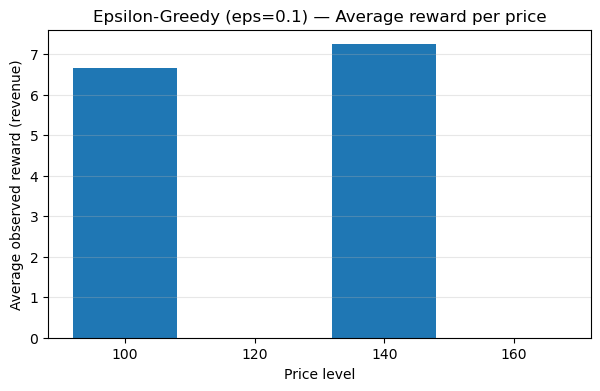

In [7]:
import matplotlib.pyplot as plt

avg_reward = bandit.average_rewards()
prices_sorted = sorted(avg_reward.keys())
avg_values = [avg_reward[p] for p in prices_sorted]

plt.figure(figsize=(7,4))
plt.bar([str(p) for p in prices_sorted], avg_values)
plt.xlabel("Price level")
plt.ylabel("Average observed reward (revenue)")
plt.title(f"Epsilon-Greedy (eps={eps}) — Average reward per price")
plt.grid(axis='y', alpha=0.3)
plt.show()


In [ ]:
## Plot: Cumulative revenue and conversions over time

These charts help visualize whether the policy is improving revenue/volume as it learns.


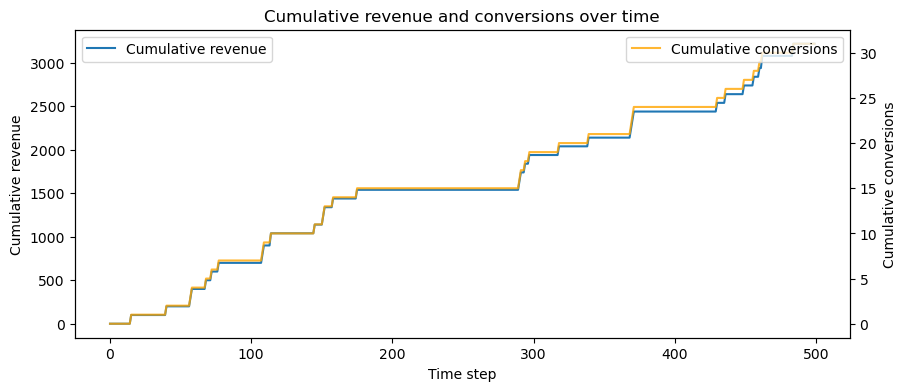

In [8]:
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(results_df['cum_revenue'], label='Cumulative revenue')
ax1.set_xlabel('Time step')
ax1.set_ylabel('Cumulative revenue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(results_df['cum_conv'], color='orange', label='Cumulative conversions', alpha=0.8)
ax2.set_ylabel('Cumulative conversions')
ax2.legend(loc='upper right')

plt.title('Cumulative revenue and conversions over time')
plt.show()


In [9]:
# Optional: save bandit stats locally (counts & rewards) for reuse
import json
save_obj = {
    "prices": bandit.prices,
    "counts": dict(bandit.counts),
    "sum_rewards": dict(bandit.rewards),
    "avg_rewards": bandit.average_rewards(),
    "eps": bandit.eps
}
with open("bandit_summary.json","w") as f:
    json.dump(save_obj, f, indent=2)

print("Saved bandit_summary.json")


TypeError: Object of type int64 is not JSON serializable

In [ ]:
## Quick interpretation & next steps

**What to look for**
- Bars in the average reward plot show which price produced higher revenue per selection.
- Cumulative revenue plot shows total revenue the policy has collected during the simulated run.

**Extensions (easy to explain in interviews)**
- Replace the observational setup with a proper **simulator** (so you always get feedback for chosen price).
- Try **LinUCB** or **Thompson Sampling** (contextual or Bayesian alternatives).
- Use **reward = w_profit * revenue + w_conv * converted** to balance objectives.
- Deploy the trained policy from notebook into the Streamlit app to demo realtime decisions.


In [10]:
pip install streamlit pandas numpy matplotlib
streamlit run streamlit_app.py


SyntaxError: invalid syntax (2905289014.py, line 1)